In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
path_data = '../../../data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

### Causality ###

Our methods for comparing two samples have a powerful use in the analysis of randomized controlled experiments. Since the treatment and control groups are assigned randomly in such experiements, differences in their outcomes can be compared to what would happen just due to chance if the treatment had no effect at all. If the observed differences are more marked than what we would predict as purely due to chance, we will have evidence of *causation*. Because of the unbiased assignment of individuals to the treatment and control groups, differences in the outcomes of the two groups can be ascribed to the treatment.

The key to the analysis of randomized controlled experiments is understanding exactly how chance enters the picture. This helps us set up clear null and alternative hypotheses. Once that's done, we can simply use the methods of the previous sections to complete the analysis.

Let's see how to do this in an example.

### Treating Chronic Back Pain: A Randomized Controlled Trial ###
Low-back pain in adults can be very persistent and hard to treat. Common methods run the gamut from corticosteroids to acupuncture. A [randomized controlled trial (RCT)](https://www.ncbi.nlm.nih.gov/pubmed/11376175) examined the effect of using Botulinum Toxin A as a treatment. Botulinum toxin is a neurotoxic protein that causes the disease botulism; [Wikipedia](https://en.wikipedia.org/wiki/Botulinum_toxin) says that botulinum "is the most acutely lethal toxin known." There are seven types of botulinum toxin. Botulinum Toxin A is one of the types that can cause disease in humans, but it is also used in medicine to treat various diseases involving the muscles. The RCT analyzed by Foster, Clapp, and Jabbari in 2001 examined it as a treatment for low back pain.

Thirty one patients with low-back pain were randomized into treatment and control groups, with 15 in the treatment group and 16 in control. The control group was given normal saline, and the trials were run double-blind so that neither doctors nor patients knew which group they were in.

Eight weeks after the start of the study, nine of the 15 in the treatment group and two of the 16 in the control group had pain relief (according to a precise definition used by the researchers). These data are in the table `bta` and appear to show that the treatment has a clear benefit.

In [3]:
bta = Table.read_table(path_data + 'bta.csv')
bta.show()

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


Remember that counting is the same as adding zeros and ones. The sum of 1's in the control group is the number of control group patients who had pain relief. So the *average* of the number of 1's is the *proportion* of control group patients who had pain relief.

In [3]:
bta.group('Group', np.mean)

Group,Result mean
Control,0.125
Treatment,0.6


In the treatment group, 60% of the patients had pain relief, compared to only 12.5% in the control group. None of the patients suffered any side effects. 

So the indications are that botulinum toxin A did better than the saline. But the conclusion isn't yet a slam-dunk. The patients were assigned at random into the two groups, so perhaps the difference could just be due to chance?

To understand what this means, we have to consider the possibility that among the 31 people in the study, some were simply better able to recover than others, even without any help from the treatment. What if an unusually large proportion of them got assigned to the treatment group, just by chance? Then even if the treatment did nothing more than the saline in the control group, the results of the treatment group might look better than those of the control group. 

To account for this possibility, let's start by carefully setting up the chance model.

### Potential Outcomes ###
Before the patients are randomized into the two groups, our minds instinctively imagine two possible outcomes for each patient: the outcome that the patient would have if assigned to the treatment group, and the outcome that the same patient would have if assigned to the control group. These are called the two *potential outcomes* of the patient.

Thus there are 31 potential treatment outcomes and 31 potential control ouctomes. The question is about the distributions of these two sets of 31 outcomes each. Are they the same, or are they different?

We can't answer this just yet, because we don't get to see all 31 values in each group. We just get to see a randomly selected 16 of the potential control outcomes, and the treatment outcomes of *the remaining* 15 patients. 

Here is a good way to visualize the setting. Each patient has a two-sided ticket:

![Two-sided ticket](../../../images/causality1.png)

After the randomization, we get to see the right half of a randomly selected set of tickets, and the left half of the remaining group.

![Half-tickets](../../../images/causality2.png)

The table `observed_outcomes` collects the information about every patient's potential outcomes, leaving the unobserved half of each "ticket" blank.  (It's just another way of thinking about the `bta` table, carrying the same information.)

In [66]:
observed_outcomes = Table.read_table(path_data + "observed_outcomes.csv")
observed_outcomes.show()

Group,Outcome if assigned treatment,Outcome if assigned control
Control,Unknown,1
Control,Unknown,1
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0


### The Hypotheses ###
The question is whether the treatment does anything. In terms of the table `observed_outcomes`, the question is whether the distribution of the 31 "treatment" values in Column 1  (including the unknown ones) is different from the distribution of the 31 "control" values in Column 2 (again including the unknown ones).

**Null Hypothesis:** The distribution of all 31 potential "treatment" outcomes is the same as that of all 31 potential "control" outcomes. Botulinum toxin A does nothing different from saline; the difference in the two samples is just due to chance.

**Alternative Hypothesis:** The distribution of 31 potential "treatment" outcomes is different from that of the 31 control outcomes. The treatment does something different from the control.

There are 31 observed outcomes jointly in the two groups. If the null hypothesis were true, it wouldn't matter which of those 31 outcomes were labeled "treatment" and which "control." Any random subset of 16 out of the 31 values could be called "control" and the remaining 15 "treatment".

We can simulate this. We can randomly permute the 31 values, split them into two groups of 16 and 15, and see how different the distributions in the two groups are. Since the data are zeros and ones, we can just see how different the two proportions are. 

That's exactly what we did for A/B testing in the previous section. Sample A is now the control group and Sample B the treatment group. We will carry out the test below showing the details of all the steps. You should confirm that they are the same as the steps carried out for A/B testing.

### The Test Statistic ###
If the two group proportions are very different from each other, we will lean towards the alternative hypothesis that the two underlying distributions are different. So our test statistic will be the distance between the two group proportions, that is, the absolute value of the difference between them.

Large values of the test statistic will favor the alternative hypothesis over the null.

Since the two group proportions were 0.6 and 0.125, the observed value of the test statistic is $\big{\vert} 0.6 - 0.125 \big{\vert} = 0.475$. 

In [33]:
bta.group('Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6


In [34]:
observed_proportions = bta.group('Group', np.average).column(1)
observed_distance = abs(observed_proportions.item(0) - observed_proportions.item(1))
observed_distance

0.475

### Predicting the Statistic Under the Null Hypothesis ###
We can simulate results under the null hypothesis, to see how our test statistic should come out if the null hypothesis is true.

#### Generating One Value of the Statistic ####
The simulation follows exactly the same process we used in the previous section. We start by randomly permuting the `results` column and assigning "control" and "treatment" labels to the permuted results. 

In [16]:
shuffled_results = bta.sample(with_replacement=False).column(1)

In [19]:
bta_with_shuffled_results = bta.with_column('Shuffled Results', shuffled_results)
bta_with_shuffled_results.show()

Group,Result,Shuffled Results
Control,1,0
Control,1,0
Control,0,0
Control,0,0
Control,0,1
Control,0,0
Control,0,0
Control,0,1
Control,0,0
Control,0,0


We then get the group means of the shuffled results:

In [20]:
bta_with_shuffled_results.group('Group', np.average)

Group,Result average,Shuffled Results average
Control,0.125,0.25
Treatment,0.6,0.466667


The group proportions in the "shuffled" column look quite different from those in the study's results. 

We can use the simulated proportions to calculate the simulated value of the test statistic. By doing this repeatedly, we will get a sense of how the statistic varies under the null hypothesis.

In [21]:
proportions = bta_with_shuffled_results.group('Group', np.average).column(2)
simulated_distance = abs(proportions.item(0) - proportions.item(1))
simulated_distance

0.21666666666666667

### Permutation Test ###
You can see that we are doing exactly what we did in our previous examples of the permutation test. Here is the function we defined earlier to generate the simulated differences under the null hypothesis. It simply collects the code above and puts it in the body of a `for` loop.

In [40]:
def permuted_sample_average_difference(table, label, group_label, repetitions):
    
    tbl = table.select(group_label, label)
    
    differences = make_array()
    for i in np.arange(repetitions):
        shuffled = tbl.sample(with_replacement = False).column(1)
        original_and_shuffled = tbl.with_column('Shuffled Data', shuffled)

        shuffled_means = original_and_shuffled.group(group_label, np.average).column(2)
        simulated_difference = shuffled_means.item(1) - shuffled_means.item(0)
    
        differences = np.append(differences, simulated_difference)
    
    return differences   

We will call this function to generate an array of differences between proportions in randomly selected "control" and "treatment" groups.

In [45]:
differences = permuted_sample_average_difference(bta, 'Result', 'Group', 20000)

Our statistic is the distance between the two proportions, that is, the absolute value of the difference.

In [46]:
distances = np.abs(differences)

### Conclusion of the Test ###
The array `distances` contains 20,000 values of our test statistic simulated under the null hypothesis. 

To find the P-value of the test, remember that large values of the test statitsic favor the alternative hypothesis. So the empirical P-value is the proportion of simulated statistics that were equal to or larger than the observed statistic.

In [47]:
empirical_P = np.count_nonzero(distances >= observed_distance) / repetitions
empirical_P

0.01015

This is a small P-value. The observed statistc, shown as the red dot below, is in the tail of the empirical histogram of the test statistic generated under the null hypothesis.

The result is statistically significant. The test favors the alternative hypothesis more than the null. The evidence supports the hypothesis that the treatment is doing something.

Observed Distance 0.475
Empirical P-value: 1.01 %


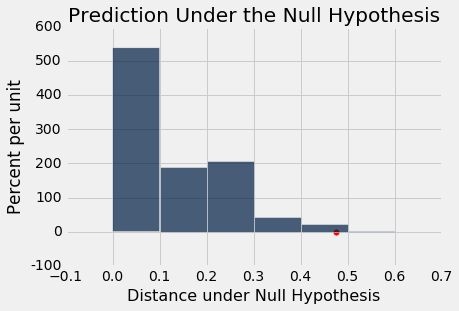

In [48]:
Table().with_column('Distance under Null Hypothesis', distances).hist(bins = np.arange(0, 0.7, 0.1))
plots.scatter(observed_distance, 0, color='red', s=30)
plots.title('Prediction Under the Null Hypothesis')
print('Observed Distance', observed_distance)
print('Empirical P-value:', round(empirical_P, 4) *100, '%')

The study reports a P-value of 0.009, or 0.9%, which is not far from our empirical value. 

### Causality ###
Because the trials were randomized, the test is evidence that the treatment *causes* the difference. The random assignment of patients to the two groups ensures that there is no confounding variable that could affect the conclusion of causality.

If the treatment had not been randomly assigned, our test would still point toward an *association* between the treatment and back pain outcomes among our 31 patients.  But beware: without randomization, this association would not imply that the treatment caused a change in back pain outcomes.  For example, if the patients themselves had chosen whether to administer the treatment, perhaps the patients experiencing more pain would be more likely to choose the treatment *and* more likely to experience some reduction in pain even without medication.  Pre-existing pain would then be a *confounding factor* in the analysis.

### A Meta-Analysis ###

While the RCT does provide evidence that the botulinum toxin A treatment helped patients, a study of 31 patients isn't enough to establish the effectiveness of a medical treatment. This is not just because of the small sample size.  Our results in this section are valid for the 31 patients in the study, but we are really interested in the population of *all possible patients*.  If the 31 patients were a random sample from *that* larger population, our confidence interval would be valid for that population.  But they were not a random sample.

In 2011, a group of researchers performed a [meta-analysis](https://www.ncbi.nlm.nih.gov/pubmed/21249702) of the studies on the treatment. That is, they identified all the available studies of such treatments for low-back pain and summarized the collated results. 

There were several studies but not many could be included in a scientifically sound manner: "We excluded evidence from nineteen studies due to non-randomisation, incomplete or unpublished data." Only three randomized controlled trials remained, one of which is the one we have studied in this section. The meta-analysis gave it the highest assessment among all the studies (LBP stands for low-back pain): "We identified three studies that investigated the merits of BoNT for LBP, but only one had a low risk of bias and evaluated patients with non-specific LBP (N = 31)." 

Putting it all together, the meta-analysis concluded, "There is low quality evidence that BoNT injections improved pain, function, or both better than saline injections and very low quality evidence that they were better than acupuncture or steroid injections. ...  Further research is very likely to have an important impact on the estimate of effect and our confidence in it. Future trials should standardize patient populations, treatment protocols and comparison groups, enlist more participants and include long-term outcomes, cost-benefit analysis and clinical relevance of findings."

It takes a lot of careful work to establish that a medical treatment has a beneficial effect. Knowing how to analyze randomized controlled trials is a crucial part of this work. Now that you know how to do that, you are well positioned to help medical and other professions establish cause-and-effect relations.